In [1]:
import os
from itertools import product
from typing import Dict

import numpy as np
import pandas as pd
import plotly.offline as py
from matplotlib import pyplot as plt
from tqdm import tqdm

from simple_portfolio import adaptive_filters
from simple_portfolio import macd
from simple_portfolio.utils import process_profitchart_data
from simple_portfolio.bollinger import BollingerBands, LMSBands, ESBands, RLSBands, IdealBands
from simple_portfolio.portfolio import Portfolio

In [2]:
py.init_notebook_mode(connected=True)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]

In [4]:
dolfut_1 = pd.read_csv('data/dados_dolfut/DOLFUT_1min.csv', sep=';', encoding='utf-8', dtype=str)
indfut_1 = pd.read_csv('data/dados_indfut/INDFUT_1min.csv', sep=';', encoding='utf-8', dtype=str)

dolfut_1 = process_profitchart_data(dolfut_1)
indfut_1 = process_profitchart_data(indfut_1)

In [5]:
dolfut_1.head()

,,open,high,low,close,volume,quantity
datetime,asset,,,,,,
2018-10-11 17:59:00,DOLFUT,3858.832,3858.832,3858.832,3858.832,947375.0,5
2018-10-15 09:00:00,DOLFUT,3831.338,3832.865,3829.811,3831.338,189994625.0,1010
2018-10-15 09:01:00,DOLFUT,3831.338,3838.975,3830.320,3836.939,417024250.0,2215
2018-10-15 09:02:00,DOLFUT,3836.430,3838.975,3833.375,3836.430,137518000.0,730
2018-10-15 09:03:00,DOLFUT,3836.939,3838.975,3835.920,3835.920,120586250.0,640


In [9]:
bands_dol_ideal = IdealBands(indfut_1, 11, 2, 27)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(bands_dol_ideal.quotes.iloc[20000:], 
                   bands_dol_ideal.signals.iloc[20000:])

11773000.0

In [10]:
portfolio


        Portfolio:
            ----
        Available Capital: 11773000.0
        Allocated Capital: 19375

        Current Positions: 
        PositionStore containing the following positions:

        Asset INDFUT: 155 outstanding LONG contracts.

        

## Bollinger Bands
The formula for constructing the bands is, typically:

$$TP = \frac{(High + Low + Close)}{3}$$
$$BB_{center} = MA(TP, n)$$
$$BB_{upper} = MA(TP, n) + m * \sigma(TP, n)$$
$$BB_{lower} = MA(TP, n) - m * \sigma(TP, n)$$

where

$BB =$ Bollinger Band

$MA(X, k) =$ Moving Average of signal X over last k periods

$\sigma(X, k) =$ Standard Deviation of signal X over last k periods

$n =$ number of periods to consider

$m =$ number of standard deviations to offset the bands by

## Os conjuntos de dados

In [6]:
fim_otimizacao_tradicional = 20000
fim_otimizacao_modificado = 40000

In [7]:
lms_start_sample = 200
es_start_sample = 2100
rls_start_sample = 100

## Start evaluating trading with a strategy

### Encontrando uma boa parametrização da técnica clássica

In [25]:
# Objetivo
max_capital = 0
params_max_capital = None

# Universo de Parâmetros
all_num_periods = [13, 17, 21]
all_stddev = [2, 2.5]
all_long_term_std_mult = [2, 2.5, 3]

for i, (num_periods, stddev, long_term_std_mul) in enumerate(
    product(all_num_periods, all_stddev, all_long_term_std_mult)
):
    bands_dol = BollingerBands(dolfut_1, num_periods, stddev, int(long_term_std_mul*num_periods))
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(bands_dol.quotes.iloc[:fim_otimizacao_tradicional],
                                           bands_dol.signals.iloc[:fim_otimizacao_tradicional])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {num_periods}, {stddev}, {int(long_term_std_mul*num_periods)}, {available_capital}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        params_max_capital = (num_periods, stddev, long_term_std_mul)

Iteration 0: 13, 2, 26, 10062514.350000022, 37500
Iteration 1: 13, 2, 32, 9990194.275000015, 37500
Iteration 2: 13, 2, 39, 10040790.504999997, 10000
Iteration 3: 13, 2.5, 26, 10052526.834999999, 43125
Iteration 4: 13, 2.5, 32, 10052850.494999997, 16250
Iteration 5: 13, 2.5, 39, 10088693.184999995, 3750
Iteration 6: 17, 2, 34, 10021817.11000002, 62500
Iteration 7: 17, 2, 42, 10012345.200000009, 62500
Iteration 8: 17, 2, 51, 10030448.140000021, 75000
Iteration 9: 17, 2.5, 34, 10046982.705000004, 0
Iteration 10: 17, 2.5, 42, 10103063.240000002, 12500
Iteration 11: 17, 2.5, 51, 10104867.46, 25000
Iteration 12: 21, 2, 42, 10054411.15000002, 50000
Iteration 13: 21, 2, 52, 10076052.920000007, 62500
Iteration 14: 21, 2, 63, 10088565.39999999, 62500
Iteration 15: 21, 2.5, 42, 10069348.045, 12500
Iteration 16: 21, 2.5, 52, 10083880.675000003, 0
Iteration 17: 21, 2.5, 63, 10080807.55999999, 0


In [26]:
periods, stddev, mult = params_max_capital
bands_dol = BollingerBands(dolfut_1, periods, stddev, int(mult * periods))
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(bands_dol.quotes.iloc[fim_otimizacao_modificado:], 
                   bands_dol.signals.iloc[fim_otimizacao_modificado:])

7110269.17499998

In [27]:
portfolio


        Portfolio:
            ----
        Available Capital: 7110269.17499998
        Allocated Capital: 3000000

        Current Positions: 
        PositionStore containing the following positions:

        Asset DOLFUT: 200 outstanding SHORT contracts.

        

In [62]:
periods, stddev, mult

(21, 2, 3)

#### Otimizando um LMS sobre os parâmetros ótimos

In [46]:
paces = [5e-10, 1e-10, 5e-11]
max_capital = 0
max_capital_pace = None
periods, stddev, mult = params_max_capital

for i, pace in enumerate(paces):
    bands_dol_lms = LMSBands(dolfut_1, 21, 2, 63, pace)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(bands_dol_lms.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           bands_dol_lms.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {num_periods}, {stddev}, {int(long_term_std_mul*stddev)}, {pace}, {available_capital}, {allocated_capital}")
    
    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_pace = pace

max_capital, max_capital_pace

Iteration 0: 21, 2, 6, 5e-10, 10073498.540000001, 28750
Iteration 1: 21, 2, 6, 1e-10, 10085962.76500002, 6875
Iteration 2: 21, 2, 6, 5e-11, 10017343.795000004, 75000


(10102248.540000001, 5e-10)

In [30]:
bands_ind_lms = LMSBands(indfut_1, 11, 2, 27, 5e-13)

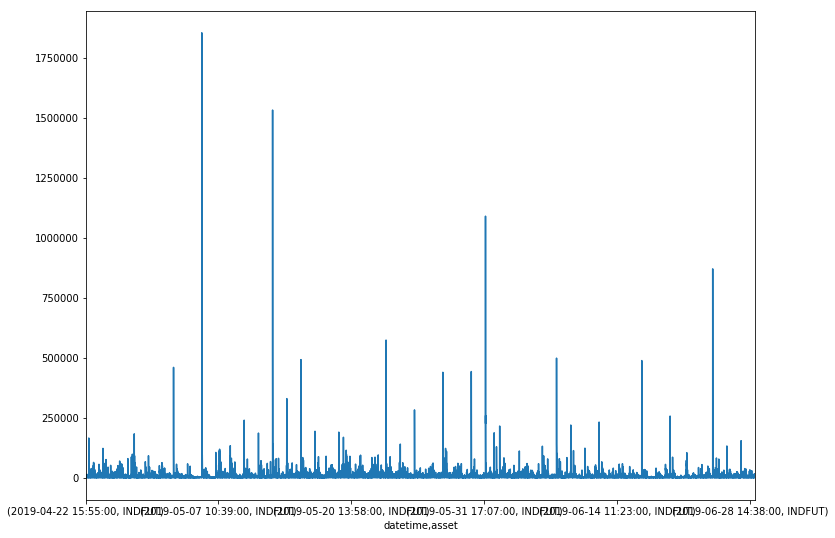

In [35]:
np.power(bands_ind_lms.quotes.eval('TP - band_center'), 2)[20000:].plot()
plt.savefig('ind_lms_dps')

In [53]:
bands_dol_lms = LMSBands(dolfut_1, periods, stddev, int(mult * periods), 5e-10)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(bands_dol_lms.quotes.iloc[fim_otimizacao_modificado:], 
                   bands_dol_lms.signals.iloc[fim_otimizacao_modificado:])

4143941.929999994

In [54]:
portfolio


        Portfolio:
            ----
        Available Capital: 4143941.929999994
        Allocated Capital: 6000000

        Current Positions: 
        PositionStore containing the following positions:

        Asset DOLFUT: 400 outstanding LONG contracts.

        

In [48]:
paces = [1e-9, 5e-10, 1e-10]
max_capital = 0
max_capital_pace = None
periods, stddev, mult = params_max_capital

for i, pace in enumerate(paces):
    bands_dol_es = ESBands(dolfut_1, 21, 2, 63, pace)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(bands_dol_es.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           bands_dol_es.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {periods}, {stddev}, {int(mult*periods)}, {pace}, {available_capital}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_pace = pace

max_capital, max_capital_pace

Iteration 0: 21, 2, 63, 1e-09, 10037277.395000018, 37500
Iteration 1: 21, 2, 63, 5e-10, 9959590.405000014, 37500
Iteration 2: 21, 2, 63, 1e-10, 9925000.0, 75000


(10074777.395000018, 1e-09)

In [50]:
bands_dol_es = ESBands(dolfut_1, periods, stddev, int(mult * periods), max_capital_pace)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(bands_dol_es.quotes.iloc[fim_otimizacao_modificado:], 
                   bands_dol_es.signals.iloc[fim_otimizacao_modificado:])

994522.4349999912

In [51]:
portfolio


        Portfolio:
            ----
        Available Capital: 994522.4349999912
        Allocated Capital: 9000000

        Current Positions: 
        PositionStore containing the following positions:

        Asset DOLFUT: 600 outstanding SHORT contracts.

        

In [55]:
lambs = [.9, .99]
sigs = [10, 50]
max_capital = 0
max_capital_params_rls = None
periods, stddev, mult = 21, 2, 3

for i, (lamb, sig) in enumerate(product(lambs, sigs)):
    bands_dol_rls = RLSBands(dolfut_1, periods, stddev, int(mult * periods), lamb, sig)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(bands_dol_rls.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           bands_dol_rls.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {periods}, {stddev}, {int(mult*stddev)}, {lamb}, {sig}, {available_capital}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_params_rls = (lamb, sig)

max_capital, max_capital_params_rls

Iteration 0: 21, 2, 6, 0.9, 10, 9882304.054999998, 75000
Iteration 1: 21, 2, 6, 0.9, 50, 9921968.635000005, 75000
Iteration 2: 21, 2, 6, 0.99, 10, 9840656.489999996, 75000
Iteration 3: 21, 2, 6, 0.99, 50, 9851284.365000006, 75000


(9996968.635000005, (0.9, 50))

In [56]:
bands_dol_rls = RLSBands(dolfut_1, periods, stddev, int(mult * periods), *max_capital_params_rls)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(bands_dol_rls.quotes.iloc[fim_otimizacao_modificado:], 
                   bands_dol_rls.signals.iloc[fim_otimizacao_modificado:])

5410520.574999988

In [57]:
portfolio


        Portfolio:
            ----
        Available Capital: 5410520.574999988
        Allocated Capital: 4500000

        Current Positions: 
        PositionStore containing the following positions:

        Asset DOLFUT: 300 outstanding SHORT contracts.

        

### MACD

In [17]:
# Objetivo
max_capital = 0
params_max_capital = None

# Universo de Parâmetros
all_shorts = range(11, 22, 2)

for i, short in enumerate(all_shorts):
    print(f"Running Iteration {i}.")
    long = 2 * short + 2
    signal = short - 2
    macd_dol = macd.MACD(dolfut_1, short, long, signal)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(macd_dol.quotes.iloc[:fim_otimizacao_tradicional],
                                           macd_dol.signals.iloc[:fim_otimizacao_tradicional])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {short}, {long}, {signal}, {available_capital}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        params_max_capital = (short, long, signal)
        
max_capital, params_max_capital

Running Iteration 0.
Iteration 0: 11, 24, 9, 10002364.429999977, 16875
Running Iteration 1.
Iteration 1: 13, 28, 11, 9938427.08499999, 49375
Running Iteration 2.
Iteration 2: 15, 32, 13, 9863572.749999998, 75000
Running Iteration 3.
Iteration 3: 17, 36, 15, 9976755.245000025, 62500
Running Iteration 4.
Iteration 4: 19, 40, 17, 9998720.375000017, 75000
Running Iteration 5.
Iteration 5: 21, 44, 19, 10054156.694999982, 50000


(10104156.694999982, (21, 44, 19))

In [18]:
max_capital, params_max_capital

(10104156.694999982, (21, 44, 19))

#### Otimizando um LMS sobre os parâmetros ótimos

In [43]:
paces = [1e-10, 5e-11]
max_capital = 0
max_capital_pace = None
short, long, signal = params_max_capital

for i, pace in enumerate(paces):
    macd_dol_lms = macd.LMS_MACD(dolfut_1, short, long, signal, pace)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(macd_dol_lms.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           macd_dol_lms.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {short}, {long}, {signal}, {available_capital}, {pace}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_pace = pace

max_capital, max_capital_pace

KeyboardInterrupt: 

In [20]:
macd_dol_lms = macd.LMS_MACD(dolfut_1, short, long, signal, max_capital_pace)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(macd_dol_lms.quotes.iloc[fim_otimizacao_modificado:], 
                   macd_dol_lms.signals.iloc[fim_otimizacao_modificado:])

10000000.0

In [21]:
paces = [1e-8, 5e-9]
max_capital = 0
max_capital_pace = None
periods, stddev, mult = params_max_capital

for i, pace in enumerate(paces):
    macd_dol_es = macd.ES_MACD(dolfut_1, short, long, signal, pace)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(macd_dol_es.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           macd_dol_es.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {short}, {long}, {signal}, {available_capital}, {pace}, {allocated_capital}")

    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_pace = pace

max_capital, max_capital_pace

D:\Studies\FEEC\pas\projeto_final\simple_portfolio\adaptive_filters.py:58: RuntimeWarning:

invalid value encountered in greater

D:\Studies\FEEC\pas\projeto_final\simple_portfolio\adaptive_filters.py:60: RuntimeWarning:

invalid value encountered in less



Iteration 0: 21, 44, 19, 10000000.0, 1e-08, 0
Iteration 1: 21, 44, 19, 10000000.0, 5e-09, 0


(10000000.0, 1e-08)

In [22]:
macd_dol_es = macd.ES_MACD(dolfut_1, short, long, signal, max_capital_pace)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(macd_dol_es.quotes.iloc[fim_otimizacao_modificado:], 
                   macd_dol_es.signals.iloc[fim_otimizacao_modificado:])

10000000.0

In [23]:
lambs = [.999, .99]
sigs = [1, 5]
max_capital = 0
max_capital_params_rls = None
short, long, signal = params_max_capital

for i, (lamb, sig) in enumerate(product(lambs, sigs)):
    macd_dol_rls = macd.RLS_MACD(dolfut_1, short, long, signal, lamb, sig)
    portfolio = Portfolio(1e7, max_single_exposition=600)
    available_capital = portfolio.backtest(macd_dol_rls.quotes.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado], 
                                           macd_dol_rls.signals.iloc[fim_otimizacao_tradicional:fim_otimizacao_modificado])
    allocated_capital = portfolio.allocated_capital
    total_capital = allocated_capital + available_capital
    print(f"Iteration {i}: {short}, {long}, {signal}, {available_capital}, {lamb}, {sig}, {allocated_capital}")
    
    if total_capital > max_capital:
        max_capital = total_capital
        max_capital_params_rls = (lamb, sig)

max_capital, max_capital_params_rls

Iteration 0: 21, 44, 19, 10000000.0, 0.999, 1, 0
Iteration 1: 21, 44, 19, 10000000.0, 0.999, 5, 0
Iteration 2: 21, 44, 19, 10000000.0, 0.99, 1, 0
Iteration 3: 21, 44, 19, 10000000.0, 0.99, 5, 0


(10000000.0, (0.999, 1))

In [24]:
macd_dol_rls = macd.RLS_MACD(dolfut_1, short, long, signal, lamb, sig)
portfolio = Portfolio(1e7, max_single_exposition=600)
portfolio.backtest(macd_dol_rls.quotes.iloc[fim_otimizacao_modificado:], 
                   macd_dol_rls.signals.iloc[fim_otimizacao_modificado:])

10000000.0